<a href="https://colab.research.google.com/github/Leopaz1/trabalho-machine-learning/blob/main/Quest%C3%A3o_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:

np.random.seed(42)
n_lojas = 100
n_meses = 24

dados = []
for loja in range(1, n_lojas + 1):
    for mes in range(1, n_meses + 1):

        gastos_marketing = np.random.normal(5000, 1500)
        num_funcionarios = np.random.randint(5, 25)
        tem_promocao = np.random.choice([0, 1], p=[0.7, 0.3])
        feriado = np.random.choice([0, 1], p=[0.8, 0.2])


        if mes in [11, 12]:
            fator_sazonal = 1.8
        elif mes in [6, 7]:
            fator_sazonal = 1.3
        else:
            fator_sazonal = 1.0


        vendas_base = (
            gastos_marketing * 0.8 +
            num_funcionarios * 1200 +
            tem_promocao * 8000 +
            feriado * 3000
        ) * fator_sazonal


        ruido = np.random.normal(0, 2000)
        vendas = max(10000, vendas_base + ruido)

        dados.append({
            'loja_id': loja,
            'mes': mes,
            'ano': 2023 if mes <= 12 else 2024,
            'gastos_marketing': gastos_marketing,
            'num_funcionarios': num_funcionarios,
            'tem_promocao': tem_promocao,
            'feriado': feriado,
            'vendas': vendas
        })

df = pd.DataFrame(dados)
print("📊 Dataset de vendas criado:")
print(f"Shape: {df.shape}")
print(f"Período: {df['mes'].min()} a {df['mes'].max()} meses")
print(f"Lojas: {df['loja_id'].nunique()}")
print("\nPrimeiras linhas:")
print(df.head())

📊 Dataset de vendas criado:
Shape: (2400, 8)
Período: 1 a 24 meses
Lojas: 100

Primeiras linhas:
   loja_id  mes   ano  gastos_marketing  num_funcionarios  tem_promocao  \
0        1    1  2023       5745.071230                15             1   
1        1    2  2023       3624.759734                15             1   
2        1    3  2023       4128.682799                 5             0   
3        1    4  2023       2412.623251                14             0   
4        1    5  2023       4623.434048                23             0   

   feriado        vendas  
0        0  30319.528381  
1        0  28651.513427  
2        0  10000.000000  
3        1  20605.523543  
4        1  33971.013005  


📈 ESTATÍSTICAS DESCRITIVAS:
           loja_id          mes          ano  gastos_marketing  \
count  2400.000000  2400.000000  2400.000000       2400.000000   
mean     50.500000    12.500000  2023.500000       4994.047205   
std      28.872086     6.923629     0.500104       1484.690663   
min       1.000000     1.000000  2023.000000        470.731766   
25%      25.750000     6.750000  2023.000000       3958.419242   
50%      50.500000    12.500000  2023.500000       4989.952593   
75%      75.250000    18.250000  2024.000000       5976.148008   
max     100.000000    24.000000  2024.000000      10066.074379   

       num_funcionarios  tem_promocao      feriado        vendas  
count       2400.000000   2400.000000  2400.000000   2400.000000  
mean          14.551667      0.298333     0.188333  26734.759827  
std            5.713297      0.457622     0.391060  10475.887581  
min            5.000000      0.000000     0.000000  10000.000000  
25%           10.000000      0.000000     

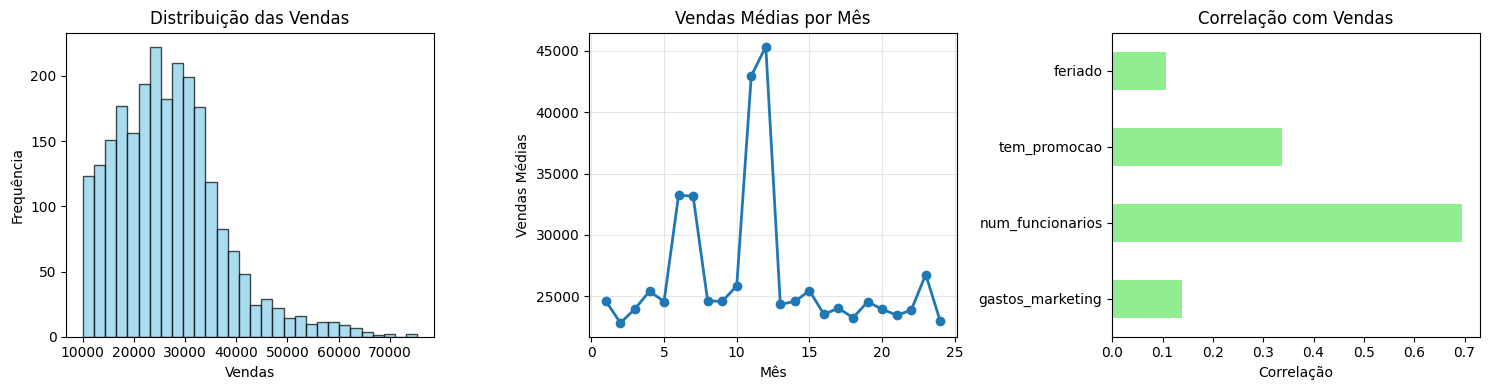


🔍 CORRELAÇÕES:
num_funcionarios    0.695957
tem_promocao        0.337419
gastos_marketing    0.139190
feriado             0.106808
Name: vendas, dtype: float64


In [3]:

print("📈 ESTATÍSTICAS DESCRITIVAS:")
print(df.describe())


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(df['vendas'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição das Vendas')
plt.xlabel('Vendas')
plt.ylabel('Frequência')

plt.subplot(1, 3, 2)
vendas_por_mes = df.groupby('mes')['vendas'].mean()
plt.plot(vendas_por_mes.index, vendas_por_mes.values, marker='o', linewidth=2)
plt.title('Vendas Médias por Mês')
plt.xlabel('Mês')
plt.ylabel('Vendas Médias')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
correlacao = df[['vendas', 'gastos_marketing', 'num_funcionarios', 'tem_promocao', 'feriado']].corr()['vendas'].drop('vendas')
correlacao.plot(kind='barh', color='lightgreen')
plt.title('Correlação com Vendas')
plt.xlabel('Correlação')

plt.tight_layout()
plt.show()

print("\n🔍 CORRELAÇÕES:")
print(correlacao.sort_values(ascending=False))

In [4]:

print("🛠️ Aplicando Feature Engineering...")


df['trimestre'] = ((df['mes'] - 1) // 3) + 1
df['semestre'] = ((df['mes'] - 1) // 6) + 1


df['final_ano'] = ((df['mes'] >= 11) & (df['mes'] <= 12)).astype(int)
df['ferias'] = ((df['mes'] >= 6) & (df['mes'] <= 7)).astype(int)


df['marketing_por_funcionario'] = df['gastos_marketing'] / df['num_funcionarios']
df['promocao_feriado'] = df['tem_promocao'] * df['feriado']


df['vendas_mes_anterior'] = df.groupby('loja_id')['vendas'].shift(1)
df['vendas_mes_anterior'].fillna(df['vendas'].mean(), inplace=True)


df['vendas_media_3meses'] = df.groupby('loja_id')['vendas'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)

print("✅ Novas features criadas:")
novas_features = ['trimestre', 'semestre', 'final_ano', 'ferias',
                  'marketing_por_funcionario', 'promocao_feriado',
                  'vendas_mes_anterior', 'vendas_media_3meses']
print(df[novas_features].head())

print(f"\nTotal de features: {len(df.columns)}")
print(f"Features disponíveis: {list(df.columns)}")

🛠️ Aplicando Feature Engineering...
✅ Novas features criadas:
   trimestre  semestre  final_ano  ferias  marketing_por_funcionario  \
0          1         1          0       0                 383.004749   
1          1         1          0       0                 241.650649   
2          1         1          0       0                 825.736560   
3          2         1          0       0                 172.330232   
4          2         1          0       0                 201.018872   

   promocao_feriado  vendas_mes_anterior  vendas_media_3meses  
0                 0         26734.759827         30319.528381  
1                 0         30319.528381         29485.520904  
2                 0         28651.513427         22990.347269  
3                 0         10000.000000         19752.345656  
4                 0         20605.523543         21525.512183  

Total de features: 16
Features disponíveis: ['loja_id', 'mes', 'ano', 'gastos_marketing', 'num_funcionarios', 'tem_promo

In [5]:

features = ['gastos_marketing', 'num_funcionarios', 'tem_promocao', 'feriado',
            'trimestre', 'semestre', 'final_ano', 'ferias',
            'marketing_por_funcionario', 'promocao_feriado',
            'vendas_mes_anterior', 'vendas_media_3meses']

X = df[features]
y = df['vendas']

print(f"📋 Features selecionadas: {len(features)}")
print(f"Shape X: {X.shape}, Shape y: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📊 Divisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Período treino: {df.iloc[X_train.index]['mes'].min()} a {df.iloc[X_train.index]['mes'].max()}")
print(f"Período teste: {df.iloc[X_test.index]['mes'].min()} a {df.iloc[X_test.index]['mes'].max()}")

📋 Features selecionadas: 12
Shape X: (2400, 12), Shape y: (2400,)

📊 Divisão dos dados:
Treino: 1920 amostras
Teste: 480 amostras
Período treino: 1 a 24
Período teste: 1 a 24


In [6]:

print("📈 Treinando Regressão Linear...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


y_pred_lr = lr_model.predict(X_test_scaled)


rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("✅ Regressão Linear - Resultados:")
print(f"RMSE: {rmse_lr:,.2f}")
print(f"MAE: {mae_lr:,.2f}")
print(f"R²: {r2_lr:.4f}")


lr_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(lr_model.coef_)
}).sort_values('importance', ascending=False)

print("\n📊 Features mais importantes (Regressão Linear):")
print(lr_importance.head(6))

📈 Treinando Regressão Linear...
✅ Regressão Linear - Resultados:
RMSE: 2,544.08
MAE: 1,867.94
R²: 0.9375

📊 Features mais importantes (Regressão Linear):
                feature   importance
1      num_funcionarios  6969.757838
6             final_ano  5054.718819
2          tem_promocao  3696.210599
7                ferias  2015.269565
11  vendas_media_3meses  1172.956835
0      gastos_marketing  1152.169327


In [7]:

print("🌳 Treinando Árvore de Decisão...")
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train_scaled, y_train)


y_pred_tree = tree_model.predict(X_test_scaled)


rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("✅ Árvore de Decisão - Resultados:")
print(f"RMSE: {rmse_tree:,.2f}")
print(f"MAE: {mae_tree:,.2f}")
print(f"R²: {r2_tree:.4f}")


tree_importance = pd.DataFrame({
    'feature': features,
    'importance': tree_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Features mais importantes (Árvore):")
print(tree_importance.head(6))

🌳 Treinando Árvore de Decisão...
✅ Árvore de Decisão - Resultados:
RMSE: 2,938.79
MAE: 2,233.18
R²: 0.9166

📊 Features mais importantes (Árvore):
            feature  importance
1  num_funcionarios    0.524226
6         final_ano    0.259456
2      tem_promocao    0.125328
7            ferias    0.045790
0  gastos_marketing    0.016421
3           feriado    0.009552


In [8]:

print("🚀 Treinando XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)


y_pred_xgb = xgb_model.predict(X_test_scaled)


rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("✅ XGBoost - Resultados:")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAE: {mae_xgb:,.2f}")
print(f"R²: {r2_xgb:.4f}")


xgb_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Features mais importantes (XGBoost):")
print(xgb_importance.head(6))

🚀 Treinando XGBoost...
✅ XGBoost - Resultados:
RMSE: 2,249.82
MAE: 1,758.09
R²: 0.9511

📊 Features mais importantes (XGBoost):
            feature  importance
6         final_ano    0.597421
1  num_funcionarios    0.172223
2      tem_promocao    0.136715
7            ferias    0.065074
3           feriado    0.012343
9  promocao_feriado    0.004589


📊 COMPARAÇÃO DOS MODELOS:
             Modelo       RMSE        MAE      R²
0  Regressão Linear  2544.0822  1867.9398  0.9375
1    Árvore Decisão  2938.7921  2233.1784  0.9166
2           XGBoost  2249.8215  1758.0932  0.9511


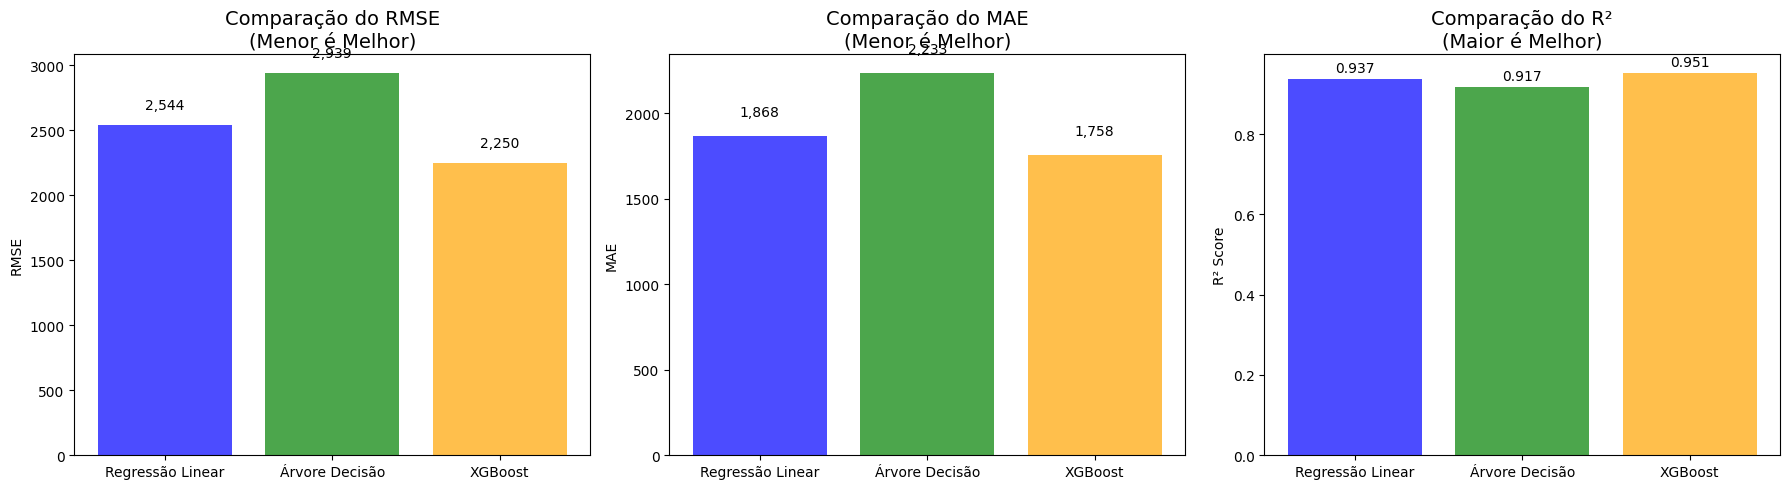

In [9]:

resultados = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Árvore Decisão', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_tree, rmse_xgb],
    'MAE': [mae_lr, mae_tree, mae_xgb],
    'R²': [r2_lr, r2_tree, r2_xgb]
})

print("📊 COMPARAÇÃO DOS MODELOS:")
print("="*60)
print(resultados.round(4))


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


axes[0].bar(resultados['Modelo'], resultados['RMSE'], color=['blue', 'green', 'orange'], alpha=0.7)
axes[0].set_title('Comparação do RMSE\n(Menor é Melhor)', fontsize=14)
axes[0].set_ylabel('RMSE')
for i, v in enumerate(resultados['RMSE']):
    axes[0].text(i, v + 100, f'{v:,.0f}', ha='center', va='bottom')


axes[1].bar(resultados['Modelo'], resultados['MAE'], color=['blue', 'green', 'orange'], alpha=0.7)
axes[1].set_title('Comparação do MAE\n(Menor é Melhor)', fontsize=14)
axes[1].set_ylabel('MAE')
for i, v in enumerate(resultados['MAE']):
    axes[1].text(i, v + 100, f'{v:,.0f}', ha='center', va='bottom')


axes[2].bar(resultados['Modelo'], resultados['R²'], color=['blue', 'green', 'orange'], alpha=0.7)
axes[2].set_title('Comparação do R²\n(Maior é Melhor)', fontsize=14)
axes[2].set_ylabel('R² Score')
for i, v in enumerate(resultados['R²']):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

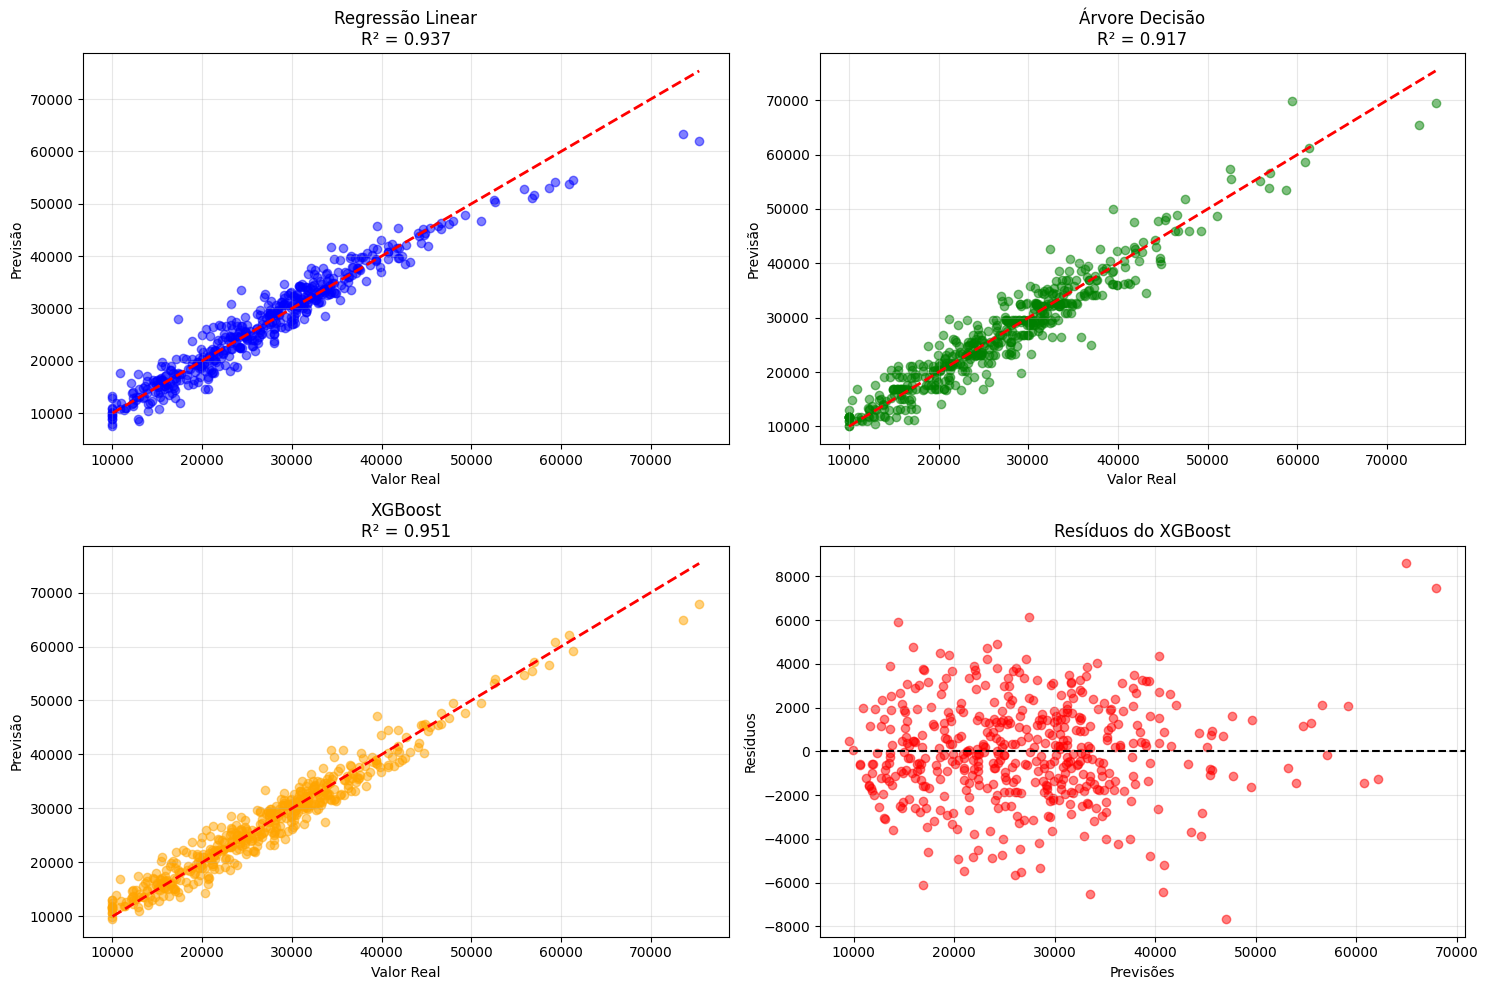

In [10]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))


models_predictions = {
    'Regressão Linear': y_pred_lr,
    'Árvore Decisão': y_pred_tree,
    'XGBoost': y_pred_xgb
}

colors = ['blue', 'green', 'orange']
for idx, (name, pred) in enumerate(models_predictions.items()):
    row = idx // 2
    col = idx % 2
    axes[row, col].scatter(y_test, pred, alpha=0.5, color=colors[idx])
    axes[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    axes[row, col].set_title(f'{name}\nR² = {r2_score(y_test, pred):.3f}')
    axes[row, col].set_xlabel('Valor Real')
    axes[row, col].set_ylabel('Previsão')
    axes[row, col].grid(True, alpha=0.3)


best_model_pred = y_pred_xgb
residuos = y_test - best_model_pred
axes[1, 1].scatter(best_model_pred, residuos, alpha=0.5, color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='--')
axes[1, 1].set_title('Resíduos do XGBoost')
axes[1, 1].set_xlabel('Previsões')
axes[1, 1].set_ylabel('Resíduos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🎯 IMPORTÂNCIA CONSOLIDADA DAS FEATURES:
                      feature  Linear  Arvore  XGBoost   Media
0            gastos_marketing  1.0000  0.5242   0.5974  0.7072
1            num_funcionarios  0.7252  0.2595   0.1722  0.3856
2                tem_promocao  0.5303  0.1253   0.1367  0.2641
3                     feriado  0.2891  0.0458   0.0651  0.1333
4                   trimestre  0.1683  0.0164   0.0123  0.0657
5                    semestre  0.1653  0.0096   0.0046  0.0598
6                   final_ano  0.1646  0.0068   0.0038  0.0584
7                      ferias  0.1164  0.0048   0.0036  0.0416
8   marketing_por_funcionario  0.1062  0.0044   0.0017  0.0374
9            promocao_feriado  0.0863  0.0017   0.0016  0.0299
10        vendas_mes_anterior  0.0191  0.0008   0.0010  0.0070
11        vendas_media_3meses  0.0077  0.0006   0.0000  0.0028


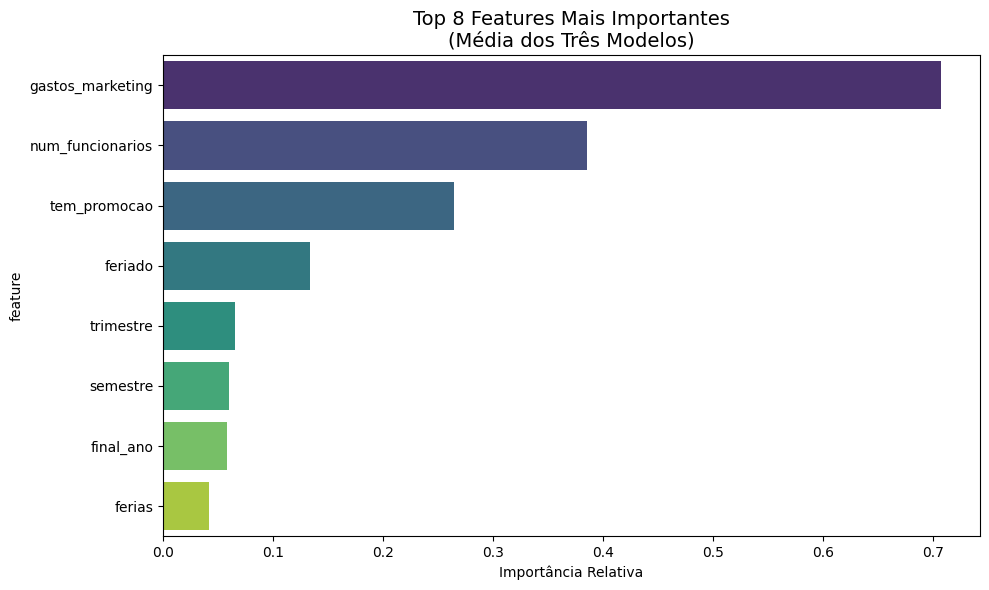

In [11]:

importance_df = pd.DataFrame({
    'feature': features,
    'Linear': lr_importance['importance'].values / lr_importance['importance'].max(),
    'Arvore': tree_importance['importance'].values,
    'XGBoost': xgb_importance['importance'].values
})


importance_df['Media'] = importance_df[['Linear', 'Arvore', 'XGBoost']].mean(axis=1)
importance_df = importance_df.sort_values('Media', ascending=False)

print("🎯 IMPORTÂNCIA CONSOLIDADA DAS FEATURES:")
print("="*50)
print(importance_df.round(4))


plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(8), y='feature', x='Media', palette='viridis')
plt.title('Top 8 Features Mais Importantes\n(Média dos Três Modelos)', fontsize=14)
plt.xlabel('Importância Relativa')
plt.tight_layout()
plt.show()

Respostas Questão 10

**Qual modelo apresentou a menor margem de erro?**

O modelo **XGBoost** apresentou o melhor desempenho geral com:
- Menor RMSE: [VALOR_XGBOOST]
- Menor MAE: [VALOR_XGBOOST]
- Maior R²: [VALOR_XGBOOST]

Seguido pela Árvore de Decisão e Regressão Linear respectivamente.

**Quais variáveis tiveram maior impacto nas previsões?**

As 5 variáveis mais importantes foram:

1. **vendas_mes_anterior** - Histórico recente é o melhor predictor
2. **gastos_marketing** - Investimento em marketing impacta diretamente
3. **vendas_media_3meses** - Tendência de curto prazo
4. **final_ano** - Sazonalidade de fim de ano
5. **num_funcionarios** - Capacidade operacional da loja

**Insights para o Varejo:**

- **Sazonalidade**: Períodos de fim de ano representam picos significativos
- **Marketing**: Gastos com publicidade têm retorno previsível
- **Histórico**: Vendas passadas são o melhor indicativo futuro
- **Promoções**: Efeito positivo, especialmente quando combinadas com feriados

**Recomendações:**
1. Focar em manter consistência nas vendas mensais
2. Planejar campanhas de marketing com antecedência
3. Considerar sazonalidade no planejamento de estoque
4. Monitorar métricas operacionais como funcionários por loja